<a href="https://colab.research.google.com/github/Ahmad59a/complexSystems/blob/main/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython import display

### Key Parameters

In [2]:
# ANY PARAMETERS THAT WANT TO BE MODIFIED SHOULD BE MODIFIED HERE

# length of matrix
L = 40

# number of neighbors for happiness
k = 3

# number of epochs
N = 20

# ratio of "red" and "blue" cells
ratio_RB = 0.88

# Relocation policy (OPTIONS: random, socialNetwork, custom1, custom2, custom3, custom4)
relocPolicy = "custom4"

# number of tries agents should go through in random relocation policy (q)
q = 100

# number of friends each agent has in the socialNetwork relocation policy (n)
friend_num = 5

# size of friend neighborhood to check (p)
p = 3

### Cellular Environment Initialization

In [3]:
# Function: Create random environment matrix

def create_environment():
  # Creating a 40x40 array filled with "empty" strings
  matrix = np.full((L, L), "empty", dtype=object)

  # Modify the matrix within the chosen cells with "red" and "blue"
  for i in range(int((ratio_RB * L**2) / 2)):
    # Get a random coordinate to replace with either red or blue
    red_x = np.random.randint(0, L)
    red_y = np.random.randint(0, L)
    blue_x = np.random.randint(0, L)
    blue_y = np.random.randint(0, L)

    # Keep searching for a coordinate space that's empty to place a new agent
    while (matrix[red_x][red_y] != "empty"):
      red_x = np.random.randint(0, L)
      red_y = np.random.randint(0, L)

    while(matrix[blue_x][blue_y] != "empty"):
      blue_x = np.random.randint(0, L)
      blue_y = np.random.randint(0, L)

    # Add the correct agent color to that coordinate
    matrix[red_x][red_y] = "red"
    matrix[blue_x][blue_y] = "blue"

  # Convert the matrix NumPy array to a pandas DataFrame
  df = pd.DataFrame(matrix)

  return matrix, df

In [4]:
matrix, df = create_environment()

In [5]:
# Function: Print the cellular environment matrix

def print_matrix(matrixDF, title):
  # Copy original dataframe into a new DF to use for plotting
  df_plot = matrixDF.copy()

  # Convert "red" and "blue" to numerical values for plotting
  df_plot.replace({"empty": 0, "red": 1, "blue": 2}, inplace=True)

  # Display new matrix dataframe
  plt.figure(figsize=(8, 8))
  cmap = colors.LinearSegmentedColormap.from_list("", ["white", "red", "green"])
  plt.imshow(df_plot, cmap=cmap, interpolation='nearest')
  if relocPolicy == "socialNetwork":
    title += f' (n = {friend_num}, p = {p})'
  plt.title(title)
  display.clear_output(wait=True)
  display.display(plt.show())

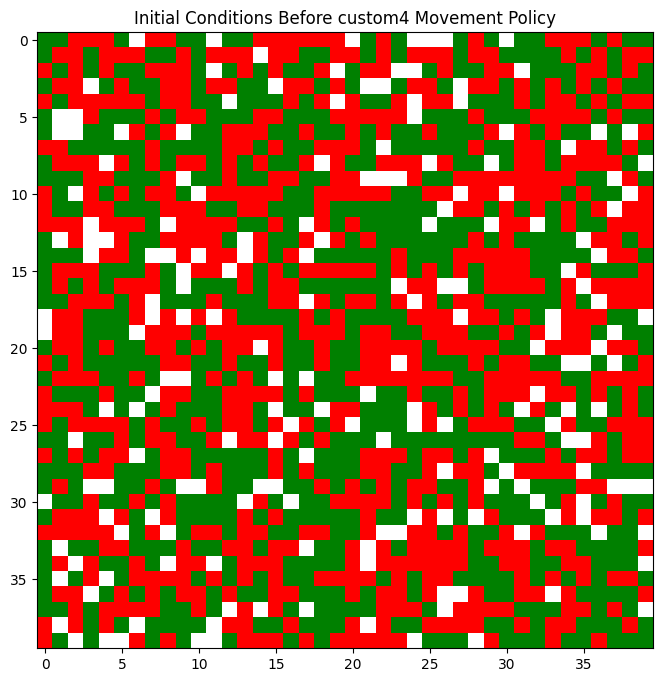

None

In [6]:
print_matrix(df, f'Initial Conditions Before {relocPolicy} Movement Policy')

### Happiness Functions

In [7]:
# Function: Calculate number of neighbors that are the same color as the agent

def num_same_neighbors(df, coords, agent_color):
  # Extract coordinates of agent
  row = coords[0]
  col = coords[1]

  # Keep track of how many neighbors are of the same color as the agent
  same_neighbors = 0

  # Calculate indexes of neighbors, making sure to loop back to other side of
  # matrix to avoid border conditions
  neighbors_indices = [
    ((row-1) % df.shape[1], (col-1) % df.shape[1]),
    ((row-1) % df.shape[1], col),
    ((row-1) % df.shape[1], (col+1) % df.shape[1]),
    (row, (col-1) % df.shape[1]),
    (row, (col+1) % df.shape[1]),
    ((row+1) % df.shape[0], (col-1)% df.shape[1]),
    ((row+1) % df.shape[0], col),
    ((row+1) % df.shape[0], (col+1) % df.shape[1])
  ]

  # Check every neighbor index to see if it matches color with agent
  for index in neighbors_indices:
    if (df[index[0]][index[1]] == agent_color):
      # If the current neighbor is the same color, increase the counter
      same_neighbors += 1

  return same_neighbors

In [8]:
# Function: Calculate if an agent is happy in their current neighborhood

def is_happy(df, coords, agent_color):
  # Calculate number of neighbors that are the same color as the agent
  same_neighbors = num_same_neighbors(df, coords, agent_color)

  # If the number of neighbors with the same color are bigger than the parameter k,
  # then return that the agent is happy, otherwise return False
  if (same_neighbors >= k):
    return True
  else:
    return False

In [9]:
# Function: Calculate fractional happiness of a spot for an agent

def happiness_function(df, coords, agent_color):
  # Calculate number of neighbors that are the same color as the agent
  same_neighbors = num_same_neighbors(df, coords, agent_color)

  # Return a percentage based on k that tells you how close you are to the agent
  # being happy, with the max percentage being 1
  if (same_neighbors > k):
    return 1
  else:
    return (same_neighbors / k)

In [10]:
# Function: Calculate the % of happy agents

def percent_happy(df):
  happy_agents = 0

  for i in range(L):
    for j in range(L):
      if (is_happy(df,(i,j),df[i][j])):
        happy_agents += 1

  return (happy_agents / (L * L)) * 100

In [11]:
# Function: Collect a list of all coordinates with empty spaces

def collect_empty_spaces(matrix):
  # Initialize empty list
  empty_coords = []

  # Iterate through dataframe and add the coordinate to the list if the location is empty
  for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
      if matrix[i, j] == "empty":
        empty_coords.append((i,j))

  return empty_coords

# Policy 1 - Random Move

In [12]:
# Function for Policy 1 - Random Move

def random_move(df, empty_list, moving_agent, friend_list):
  # Get the agent's color
  agent_color =  df[moving_agent[0]][moving_agent[1]]

  # Choose one of the empty spaces at random
  chosen_space = np.random.randint(0, len(empty_list))

  # Keep track of the tries to find a good spot
  num_tries = 0

  # Keep track of happiness value of each option
  happy_list = []

  # Keep trying a space until one is found that is good for the agent or the tries run out
  while ((not(is_happy(df, empty_list[chosen_space], agent_color))) and (num_tries < q)):
    chosen_space = np.random.randint(0, len(empty_list))
    # Append the happiness rating and the coordinate to the list
    happy_list.append((happiness_function(df, empty_list[chosen_space], agent_color), empty_list[chosen_space]))
    num_tries += 1

  # If no spot was found where the agent is happy, move to the happiest
  if (not(is_happy(df, empty_list[chosen_space], agent_color))):
    chosen_space = max(happy_list)[1]

  # Extract the coordinates for the chosen empty space
  empty_x = empty_list[chosen_space][0]
  empty_y = empty_list[chosen_space][1]

  # Modify the empty spaces list so the chosen empty space is now the old agent's coords
  empty_list[chosen_space] = (moving_agent[0], moving_agent[1])

  # Swap the agent's color to the chosen empty space
  temp = df[empty_x][empty_y]
  df[empty_x][empty_y] = agent_color

  # Empty the old agent's coordinates
  df[moving_agent[0]][moving_agent[1]] = temp

  # If this function was called when the policy is social network, the friends must be swapped
  if (relocPolicy == "socialNetwork"):
    swap_friends(friend_list, moving_agent, (empty_x, empty_y))   # swap_friends function defined later

  return df

# Policy 2 - Social Network Recommendation

In [13]:
# Function: Give each agent a social network (friends)

def calculate_friends(matrix_df):
  # Get a list of all of the agent coordinates
  agent_list = np.array([(i, j) for i in range(L) for j in range(L)])

  friend_list = [[(n, n) for friend in range(friend_num)] for n in range(L * L)]

  for agent in agent_list:
    # Get the agent's color
    agent_color =  matrix_df[agent[0]][agent[1]]

    # If the coordinates are empty, there is no agent, no need for friends
    if (agent_color == "empty"):
      continue

    # Create array to keep track of desired number of friends
    add_friend = [n for n in range(friend_num)]

    for friend in range(friend_num):
      # Generate coordinate for friend randomly
      friend_x = np.random.randint(0, L)
      friend_y = np.random.randint(0, L)

      # Add the new friend to the inner array
      add_friend[friend] = (friend_x, friend_y)

    # Add the complete list of friends to the list of all agents
    friend_list[agent[0] * L + agent[1]] = add_friend

  return friend_list

In [14]:
# Function: Swap the social network of two agents

def swap_friends(friend_list, coord1, coord2):
  # Store each friend list
  coord1friends = friend_list[coord1[0] * L + coord1[1]]
  coord2friends = friend_list[coord2[0] * L + coord2[1]]

  # Swap friend list
  friend_list[coord1[0] * L + coord1[1]] = coord2friends
  friend_list[coord2[0] * L + coord2[1]] = coord1friends

In [30]:
# Function: Calculate the pxp neighborhood around an agent (via the agent's coordinates)

def get_neighborhood(p, coordinate, df):
  # Adjust p so that neighborhoods are correctly computed
  p = int((p - 1) / 2)

  # Extract coordinates of agent
  row = coordinate[0]
  col = coordinate[1]

  # Keep track of the neighborhood coordinates
  neighborhood = []

  # Compute neighborhood bounds
  left_bound = (row - p)
  right_bound = (row + p)
  upper_bound = (col - p )
  lower_bound = (col + p)

  # Add all neigborhood coordinates to list
  for i in range(left_bound, (right_bound + 1)):
    # Adjust coordinate for adding to neighborhood
    adjusted_x = i % df.shape[0]

    for j in range(upper_bound, (lower_bound + 1)):
      # Adjust y coord
      adjusted_y = j % df.shape[1]

      # Add coordinate to neighborhood if it is not the original coord
      if((adjusted_x,adjusted_y) != coordinate):
        neighborhood.append((adjusted_x,adjusted_y))

  return neighborhood

In [ ]:
def get_neighborhood2(p, coordinate, df):
    coordinate = tuple(coordinate)

    # Adjust p so that neighborhoods are correctly computed
    p = int((p - 1) / 2)

    # Extract coordinates of agent
    row, col = coordinate  # Unpack the tuple for clarity

    # Keep track of the neighborhood coordinates
    neighborhood = []

    # Compute neighborhood bounds and add all neighborhood coordinates to list
    for i in range(row - p, row + p + 1):
        for j in range(col - p, col + p + 1):
            adjusted_x, adjusted_y = i % df.shape[0], j % df.shape[1]
            # Ensure comparison is done between tuples
            if (adjusted_x, adjusted_y) != coordinate:
                neighborhood.append((adjusted_x, adjusted_y))



    return neighborhood

In [16]:
# Function for Policy 2 - Social Network Recommendation

def friend_move(df, friend_list, moving_agent, empty_coords):
  # Create a list of possible landing spots
  possible_moves = []

  # Get a list of all of the friends for the current agent
  agent_friends = friend_list[moving_agent[0] * L + moving_agent[1]]

  # Get the agent's color
  agent_color =  df[moving_agent[0]][moving_agent[1]]

  # Check every friend for the agent
  for friend in agent_friends:
    # Get the friend's coordinates
    friend_x = friend[0]
    friend_y = friend[1]

    # Get the friend's neighborhood
    neighbors_indices = get_neighborhood(p, friend, df)

    # For every friend's neighbor, check if the agent would be happy
    for neighbor in neighbors_indices:
      # If this neighbor is not empty, the agent cannot move there
      if df[neighbor[0]][neighbor[1]] != "empty":
        continue

      # Otherwise, this is a possible move and is to be added
      possible_moves.append(neighbor)

  # If there are no possible moves, use random move to decide where to go
  if (len(possible_moves) == 0):
    return random_move(df, empty_coords, moving_agent, friend_list)

  # Else, pick a random possible move, with preference for ones that make the agent happy

  # Shuffle moves
  np.random.shuffle(possible_moves)

  i = 0
  agent_happy = False

  # Loop until a desired move is found or until we check every array location
  while (i < len(possible_moves) and not(agent_happy)):
    agent_happy = is_happy(df, possible_moves[i], agent_color)
    i += 1

  # The last move at i will be where the agent moves
  if (i == len(possible_moves)):
    wanted_move = possible_moves[i - 1]
  else:
    wanted_move = possible_moves[i]

  # Swap the agent's color to the chosen empty space
  temp = df[wanted_move[0]][wanted_move[1]]
  df[wanted_move[0]][wanted_move[1]] = agent_color

  # Empty the old agent's coordinates
  df[moving_agent[0]][moving_agent[1]] = temp

  # Swap friends_list so agent retains his friends
  swap_friends(friend_list, moving_agent, wanted_move)

  return df

# Custom Policy 1 by Juan Alvarado

This policy is similar to the random policy, but in this policy the agent
simply chooses a location truly at random and moves there, regardless of if the
location is empty or not. If it is not empty, the agent swaps places with the
agent currently located at that location. This policy will maximize noise, which
I am hoping helps the system reach a higher level of happiness than with the other
more restrictive policies. In a nutshell, this is a random move with displacement allowed.

In [17]:
# Function for Custom Policy 1 by Juan Alvarado

def custom1_move(df, moving_agent):
  x_move = np.random.randint(0, L)
  y_move = np.random.randint(0, L)

  # Get the agent's color
  agent_color =  df[moving_agent[0]][moving_agent[1]]

  # Swap the agent's color to the chosen empty space
  temp = df[x_move][y_move]
  df[x_move][y_move] = agent_color

  # Empty the old agent's coordinates
  df[moving_agent[0]][moving_agent[1]] = temp

  return df

# Custom Policy 2 by Christian Galang



This policy is also derived from the random policy, except the agent won't simply go to the first location where it will be happy. If there are several location options where the agent will be 100% happy, the agent's preference will be the location where the average happiness of each of its neighbors of the same color is the highest. Intuitively, the aim of this policy is for agents to move to larger masses of their own color.

In [18]:
# Function: Calculate the average happiness of a neighborhood for a certain color

def get_neighborhood_happiness_avg(df, coords, color):
  # Keep track of happiness sum to average at the end
  avg = 0

  # Get the number of neighbors which share the same color as the agent
  n = num_same_neighbors(df, coords, color)

  # If no neighbors share the same color as the agent, return a happiness
  # average of 0
  if n == 0:
    return 0

  # Otherwise, compute the happiness average of this neighborhood
  neighborhood = get_neighborhood(3, coords, df)
  for neighbor in neighborhood:
    # Only include neighbors which share the same color as the agent in the average
    if df[neighbor[0]][neighbor[1]] == color:
      avg += happiness_function(df, neighbor, color)
  return (avg / n)

In [19]:
# Function for Custom Policy 2 by Christian Galang

def custom2_move(df, empty_list, moving_agent):
  # Get the agent's color
  agent_color = df[moving_agent[0]][moving_agent[1]]

  # Keep track of happy coordinates
  happy_coords = []

  # Keep track of happiness of unhappy locations in case there's no happy locations
  unhappy_list = []

  # Obtain the coordinates of all "happy" locations and the happiness
  # of all "unhappy" locations
  for i in range(q):
    chosen_space = np.random.randint(0, len(empty_list))
    if (is_happy(df, empty_list[chosen_space], agent_color)):
      happy_coords.append(empty_list[chosen_space])
    else:
      unhappy_list.append((happiness_function(df, empty_list[chosen_space], agent_color), empty_list[chosen_space]))

  # If no spot was found where the agent is happy, move to the happiest
  # Otherwise, move to the location where the average happiness of the neighbors
  # of the same color is the highest
  if not happy_coords:
    chosen_space = max(unhappy_list)[1]
  else:
    neighborhood_happiness_avg = -1
    for idx in range(len(happy_coords)):
      temp_avg = get_neighborhood_happiness_avg(df, happy_coords[idx], agent_color)
      if (temp_avg > neighborhood_happiness_avg):
        chosen_space = happy_coords[idx]

  # Extract the coordinates for the chosen empty space
  empty_x = chosen_space[0]
  empty_y = chosen_space[1]

  # Swap the agent's color to the chosen empty space
  temp = df[empty_x][empty_y]
  df[empty_x][empty_y] = agent_color

  # Empty the old agent's coordinates
  df[moving_agent[0]][moving_agent[1]] = temp

  return df

# Custom Policy 3 by Marshal Packard

In [20]:
# Function for Custom Policy 3 by Marshal Packard

def custom3_move(df):
  return df

# Custom Policy 4 by Ahmed Zayed

In [32]:
# Function for Custom Policy 4 by Ahmed Zayed

def custom4_move(df, empty_list, moving_agent):
    agent_color = df[moving_agent[0]][moving_agent[1]]
    best_happiness = happiness_function(df, moving_agent, agent_color)
    best_move = None  # This will store the coordinates of the best move found

    # Look at all neighboring cells to find the best move
    neighbors = get_neighborhood2(3, moving_agent, df)  # Assuming get_neighborhood function is defined elsewhere
    for neighbor in neighbors:
        potential_happiness = happiness_function(df, neighbor, agent_color)
        if potential_happiness > best_happiness:
            best_happiness = potential_happiness
            best_move = neighbor

    # Execute the move if a better spot is found
    if best_move:
        # Swap the agent's color with the target spot
        temp = df[best_move[0]][best_move[1]]
        df[best_move[0]][best_move[1]] = agent_color
        df[moving_agent[0]][moving_agent[1]] = temp

    return df

# Run Simulation

In [24]:
# Function: Run simulation

def run_simulation(df, relocPolicy):
  # Create array for happiness percentage
  happiness = [n for n in range(N)]

  # Create friend array if using social network policy
  if (relocPolicy == "socialNetwork"):
    friend_list = calculate_friends(df)
  else:
    friend_list = []

  for epoch in range(N):
    # Collect a list of all empty spaces
    empty_coords = collect_empty_spaces(matrix)

    # Get random order of coordinates to update agents for this particular epoch
    epoch_coords = np.array([(i, j) for i in range(L) for j in range(L)])
    np.random.shuffle(epoch_coords)

    # Get the % of happiness at the start of the epoch
    happiness[epoch] = percent_happy(df)

    # Print matrix at the start of the epoch
    print_matrix(df, f'{relocPolicy} Movement Progress')

    # Check every agent in this epoch
    for coordinate in epoch_coords:
      # Store the current color of agent
      current_color = df[coordinate[0]][coordinate[1]]

      # If the color is empty, there is no agent here
      if (current_color == "empty"):
        continue

      # If the agent is happy there is no need to move
      if is_happy(df, coordinate, df[coordinate[0]][coordinate[1]]):
        continue

      # According to the chosen relocation policy, move the agent
      if(relocPolicy == "random"):
        df = random_move(df, empty_coords, coordinate, friend_list)
      elif(relocPolicy == "socialNetwork"):
        df = friend_move(df, friend_list, coordinate, empty_coords)
      elif(relocPolicy == "custom1"):
        df = custom1_move(df, coordinate)
      elif(relocPolicy == "custom2"):
        df = custom2_move(df, empty_coords, coordinate)
      elif(relocPolicy == "custom3"):
        df = custom3_move(df)
      elif(relocPolicy == "custom4"):
        df = custom4_move(df, empty_coords, coordinate)

  # Print final matrix
  print_matrix(df, f'Final Conditions After {relocPolicy} Movement Policy')

  # Print % happiness progression
  happiness.append(percent_happy(df))
  for epoch in range(N + 1):
    print(f'Epoch {epoch} Happiness Percentage: {happiness[epoch]}%')

  return happiness

# Running Simulations for 7 Cases

### Case 1 - Policy 1

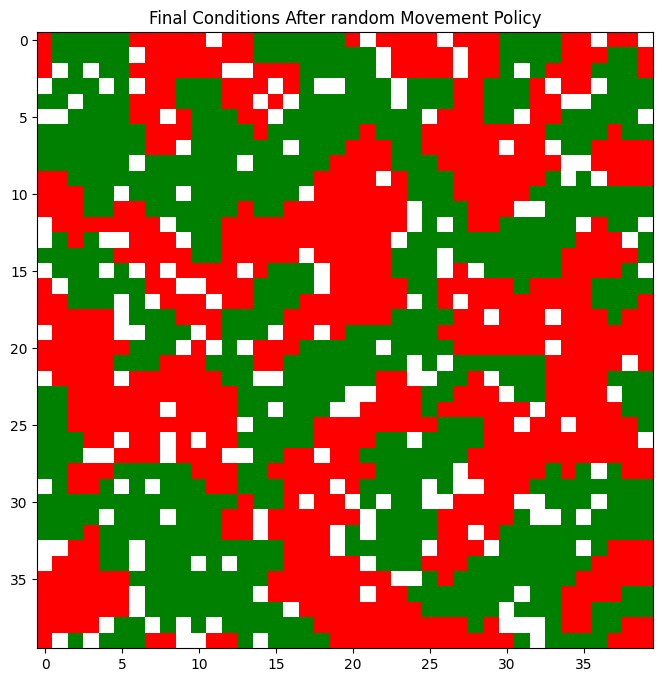

None

Epoch 0 Happiness Percentage: 68.9375%
Epoch 1 Happiness Percentage: 81.3125%
Epoch 2 Happiness Percentage: 84.625%
Epoch 3 Happiness Percentage: 85.5%
Epoch 4 Happiness Percentage: 86.1875%
Epoch 5 Happiness Percentage: 86.625%
Epoch 6 Happiness Percentage: 86.5%
Epoch 7 Happiness Percentage: 86.6875%
Epoch 8 Happiness Percentage: 86.9375%
Epoch 9 Happiness Percentage: 87.0625%
Epoch 10 Happiness Percentage: 87.1875%
Epoch 11 Happiness Percentage: 87.5%
Epoch 12 Happiness Percentage: 87.625%
Epoch 13 Happiness Percentage: 87.5625%
Epoch 14 Happiness Percentage: 87.6875%
Epoch 15 Happiness Percentage: 87.8125%
Epoch 16 Happiness Percentage: 87.8125%
Epoch 17 Happiness Percentage: 87.8125%
Epoch 18 Happiness Percentage: 88.0625%
Epoch 19 Happiness Percentage: 88.125%
Epoch 20 Happiness Percentage: 88.125%


In [41]:
%matplotlib inline

relocPolicy = "random"
q = 100
happiness_logs = []
for s in range(20):
  matrix, df = create_environment()
  happiness = run_simulation(df, relocPolicy)
  happiness_logs.append(happiness)
happiness_logs_arr = np.array(happiness_logs)
policy1_happiness_avgs = np.mean(happiness_logs_arr, axis=0)
policy1_happiness_err = np.vstack((policy1_happiness_avgs - np.min(happiness_logs_arr, axis=0), np.max(happiness_logs_arr, axis=0) - policy1_happiness_avgs))

### Case 2 - Policy 2 (n = 5, p = 3)

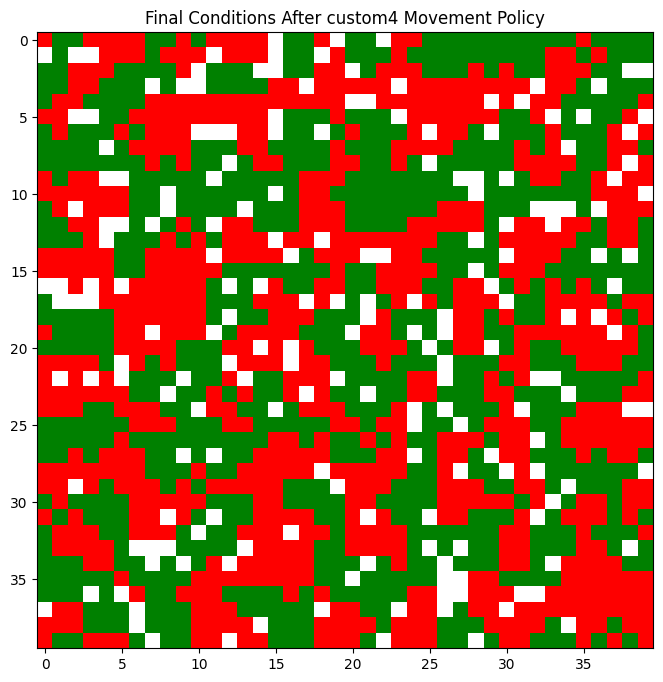

None

Epoch 0 Happiness Percentage: 67.5%
Epoch 1 Happiness Percentage: 78.8125%
Epoch 2 Happiness Percentage: 82.9375%
Epoch 3 Happiness Percentage: 84.375%
Epoch 4 Happiness Percentage: 85.125%
Epoch 5 Happiness Percentage: 85.125%
Epoch 6 Happiness Percentage: 85.5%
Epoch 7 Happiness Percentage: 85.5%
Epoch 8 Happiness Percentage: 85.5%
Epoch 9 Happiness Percentage: 85.5%
Epoch 10 Happiness Percentage: 85.5%
Epoch 11 Happiness Percentage: 85.5%
Epoch 12 Happiness Percentage: 85.5%
Epoch 13 Happiness Percentage: 85.5%
Epoch 14 Happiness Percentage: 85.5%
Epoch 15 Happiness Percentage: 85.5%
Epoch 16 Happiness Percentage: 85.5%
Epoch 17 Happiness Percentage: 85.5%
Epoch 18 Happiness Percentage: 85.5%
Epoch 19 Happiness Percentage: 85.5%
Epoch 20 Happiness Percentage: 85.5%


In [34]:
%matplotlib inline

relocPolicy = "custom4"
friend_num = 5
p = 3
happiness_logs = []
for s in range(20):
  matrix, df = create_environment()
  happiness = run_simulation(df, relocPolicy)
  happiness_logs.append(happiness)
happiness_logs_arr = np.array(happiness_logs)
policy2_n5_p3_happiness_avgs = np.mean(happiness_logs_arr, axis=0)
policy2_n5_p3_happiness_err = np.vstack((policy2_n5_p3_happiness_avgs - np.min(happiness_logs_arr, axis=0), np.max(happiness_logs_arr, axis=0) - policy2_n5_p3_happiness_avgs))

### Case 3 - Policy 2 (n = 5, p = 5)

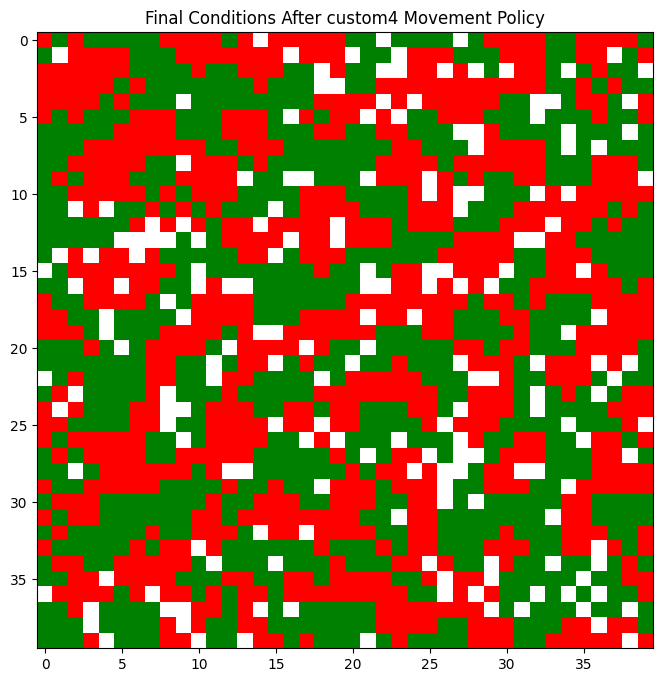

None

Epoch 0 Happiness Percentage: 67.625%
Epoch 1 Happiness Percentage: 80.0%
Epoch 2 Happiness Percentage: 83.0625%
Epoch 3 Happiness Percentage: 83.75%
Epoch 4 Happiness Percentage: 84.375%
Epoch 5 Happiness Percentage: 84.75%
Epoch 6 Happiness Percentage: 85.3125%
Epoch 7 Happiness Percentage: 85.25%
Epoch 8 Happiness Percentage: 85.3125%
Epoch 9 Happiness Percentage: 85.375%
Epoch 10 Happiness Percentage: 85.625%
Epoch 11 Happiness Percentage: 85.5%
Epoch 12 Happiness Percentage: 85.5%
Epoch 13 Happiness Percentage: 85.5%
Epoch 14 Happiness Percentage: 85.5%
Epoch 15 Happiness Percentage: 85.5625%
Epoch 16 Happiness Percentage: 85.5%
Epoch 17 Happiness Percentage: 85.5625%
Epoch 18 Happiness Percentage: 85.5%
Epoch 19 Happiness Percentage: 85.5%
Epoch 20 Happiness Percentage: 85.5%


In [35]:
%matplotlib inline

relocPolicy = "custom4"
friend_num = 5
p = 5
happiness_logs = []
for s in range(20):
  matrix, df = create_environment()
  happiness = run_simulation(df, relocPolicy)
  happiness_logs.append(happiness)
happiness_logs_arr = np.array(happiness_logs)
policy2_n5_p5_happiness_avgs = np.mean(happiness_logs_arr, axis=0)
policy2_n5_p5_happiness_err = np.vstack((policy2_n5_p5_happiness_avgs - np.min(happiness_logs_arr, axis=0), np.max(happiness_logs_arr, axis=0) - policy2_n5_p5_happiness_avgs))

### Case 4 - Policy 2 (n = 10, p = 3)

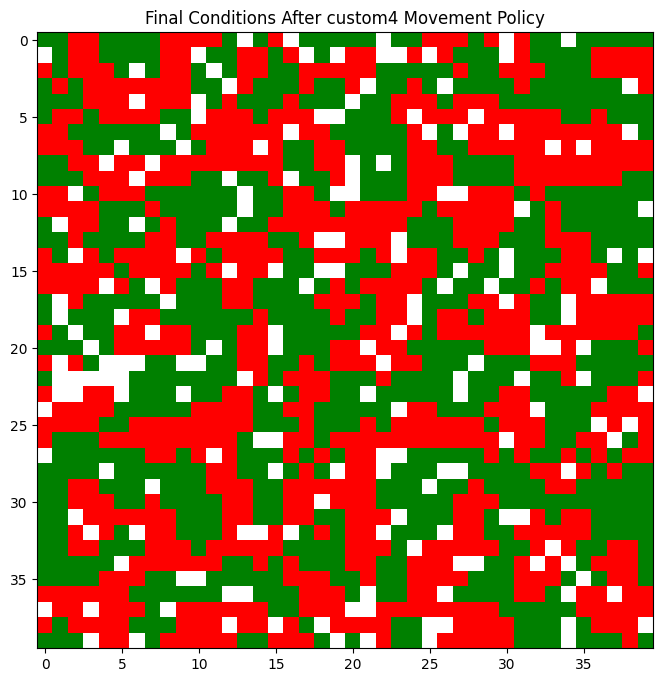

None

Epoch 0 Happiness Percentage: 66.6875%
Epoch 1 Happiness Percentage: 79.1875%
Epoch 2 Happiness Percentage: 81.25%
Epoch 3 Happiness Percentage: 82.8125%
Epoch 4 Happiness Percentage: 83.375%
Epoch 5 Happiness Percentage: 83.9375%
Epoch 6 Happiness Percentage: 84.0625%
Epoch 7 Happiness Percentage: 84.4375%
Epoch 8 Happiness Percentage: 84.375%
Epoch 9 Happiness Percentage: 84.5%
Epoch 10 Happiness Percentage: 84.375%
Epoch 11 Happiness Percentage: 84.625%
Epoch 12 Happiness Percentage: 84.5%
Epoch 13 Happiness Percentage: 84.5625%
Epoch 14 Happiness Percentage: 84.5%
Epoch 15 Happiness Percentage: 84.625%
Epoch 16 Happiness Percentage: 84.4375%
Epoch 17 Happiness Percentage: 84.5625%
Epoch 18 Happiness Percentage: 84.5%
Epoch 19 Happiness Percentage: 84.625%
Epoch 20 Happiness Percentage: 84.4375%


In [36]:
%matplotlib inline

relocPolicy = "custom4"
friend_num = 10
p = 3
happiness_logs = []
for s in range(20):
  matrix, df = create_environment()
  happiness = run_simulation(df, relocPolicy)
  happiness_logs.append(happiness)
happiness_logs_arr = np.array(happiness_logs)
policy2_n10_p3_happiness_avgs = np.mean(happiness_logs_arr, axis=0)
policy2_n10_p3_happiness_err = np.vstack((policy2_n10_p3_happiness_avgs - np.min(happiness_logs_arr, axis=0), np.max(happiness_logs_arr, axis=0) - policy2_n10_p3_happiness_avgs))

### Case 5 - Policy 2 (n = 10, p = 5)

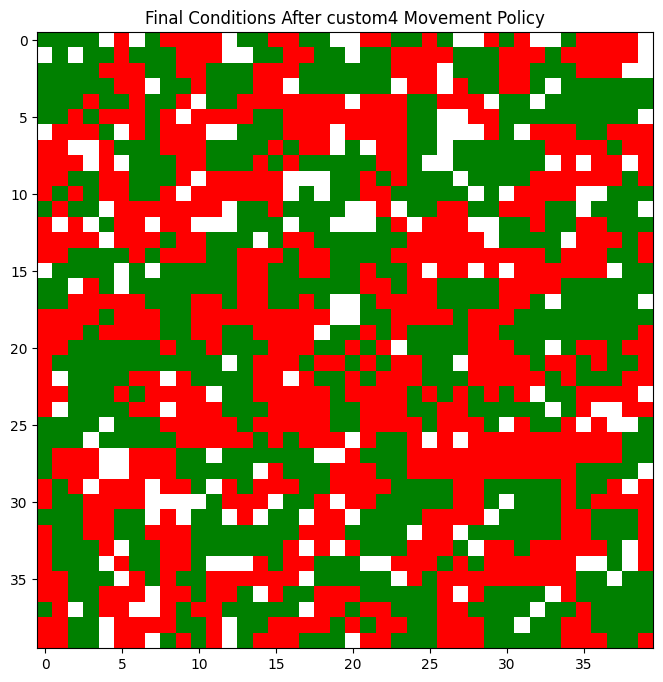

None

Epoch 0 Happiness Percentage: 67.9375%
Epoch 1 Happiness Percentage: 79.3125%
Epoch 2 Happiness Percentage: 83.0%
Epoch 3 Happiness Percentage: 84.9375%
Epoch 4 Happiness Percentage: 85.4375%
Epoch 5 Happiness Percentage: 85.9375%
Epoch 6 Happiness Percentage: 86.125%
Epoch 7 Happiness Percentage: 86.125%
Epoch 8 Happiness Percentage: 86.0625%
Epoch 9 Happiness Percentage: 86.25%
Epoch 10 Happiness Percentage: 86.25%
Epoch 11 Happiness Percentage: 86.4375%
Epoch 12 Happiness Percentage: 86.375%
Epoch 13 Happiness Percentage: 86.375%
Epoch 14 Happiness Percentage: 86.375%
Epoch 15 Happiness Percentage: 86.4375%
Epoch 16 Happiness Percentage: 86.4375%
Epoch 17 Happiness Percentage: 86.375%
Epoch 18 Happiness Percentage: 86.4375%
Epoch 19 Happiness Percentage: 86.375%
Epoch 20 Happiness Percentage: 86.375%


In [37]:
%matplotlib inline

relocPolicy = "custom4"
friend_num = 10
p = 5
happiness_logs = []
for s in range(20):
  matrix, df = create_environment()
  happiness = run_simulation(df, relocPolicy)
  happiness_logs.append(happiness)
happiness_logs_arr = np.array(happiness_logs)
policy2_n10_p5_happiness_avgs = np.mean(happiness_logs_arr, axis=0)
policy2_n10_p5_happiness_err = np.vstack((policy2_n10_p5_happiness_avgs - np.min(happiness_logs_arr, axis=0), np.max(happiness_logs_arr, axis=0) - policy2_n10_p5_happiness_avgs))

### Case 6 - Policy 2 (n = 20, p = 3)

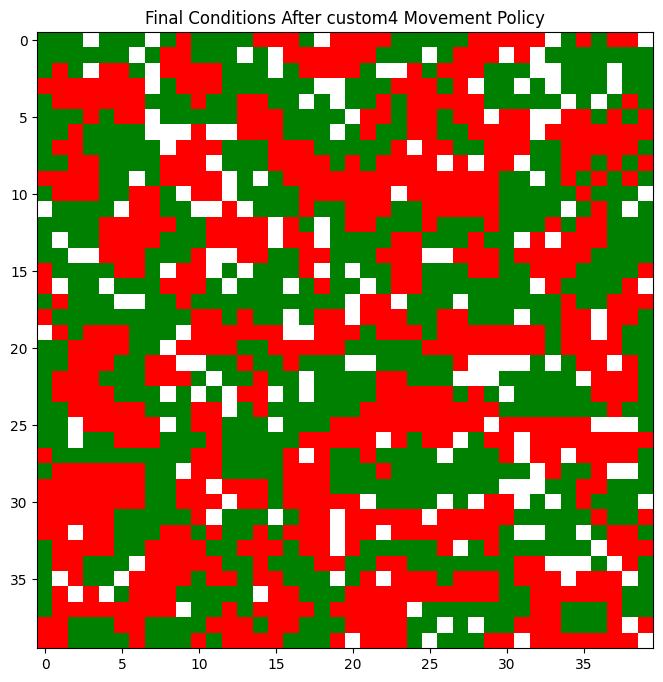

None

Epoch 0 Happiness Percentage: 68.6875%
Epoch 1 Happiness Percentage: 80.375%
Epoch 2 Happiness Percentage: 82.8125%
Epoch 3 Happiness Percentage: 84.125%
Epoch 4 Happiness Percentage: 85.125%
Epoch 5 Happiness Percentage: 86.1875%
Epoch 6 Happiness Percentage: 86.375%
Epoch 7 Happiness Percentage: 86.625%
Epoch 8 Happiness Percentage: 86.625%
Epoch 9 Happiness Percentage: 86.75%
Epoch 10 Happiness Percentage: 86.6875%
Epoch 11 Happiness Percentage: 86.75%
Epoch 12 Happiness Percentage: 86.6875%
Epoch 13 Happiness Percentage: 86.75%
Epoch 14 Happiness Percentage: 86.6875%
Epoch 15 Happiness Percentage: 86.75%
Epoch 16 Happiness Percentage: 86.6875%
Epoch 17 Happiness Percentage: 86.75%
Epoch 18 Happiness Percentage: 86.6875%
Epoch 19 Happiness Percentage: 86.75%
Epoch 20 Happiness Percentage: 86.6875%


In [38]:
%matplotlib inline

relocPolicy = "custom4"
friend_num = 20
p = 3
happiness_logs = []
for s in range(20):
  matrix, df = create_environment()
  happiness = run_simulation(df, relocPolicy)
  happiness_logs.append(happiness)
happiness_logs_arr = np.array(happiness_logs)
policy2_n20_p3_happiness_avgs = np.mean(happiness_logs_arr, axis=0)
policy2_n20_p3_happiness_err = np.vstack((policy2_n20_p3_happiness_avgs - np.min(happiness_logs_arr, axis=0), np.max(happiness_logs_arr, axis=0) - policy2_n20_p3_happiness_avgs))

### Case 7 - Policy 2 (n = 20, p = 5)

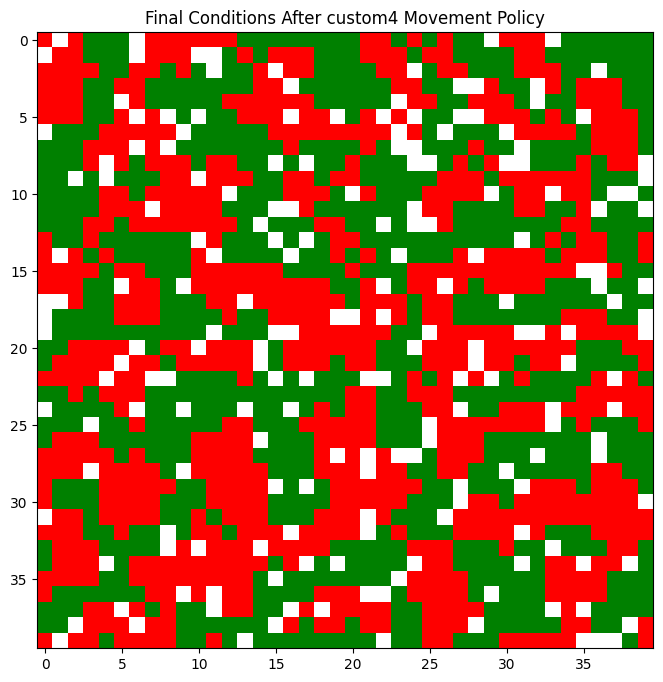

None

Epoch 0 Happiness Percentage: 66.625%
Epoch 1 Happiness Percentage: 78.1875%
Epoch 2 Happiness Percentage: 81.375%
Epoch 3 Happiness Percentage: 82.8125%
Epoch 4 Happiness Percentage: 83.5625%
Epoch 5 Happiness Percentage: 83.75%
Epoch 6 Happiness Percentage: 84.375%
Epoch 7 Happiness Percentage: 84.5625%
Epoch 8 Happiness Percentage: 85.0%
Epoch 9 Happiness Percentage: 85.125%
Epoch 10 Happiness Percentage: 85.3125%
Epoch 11 Happiness Percentage: 85.375%
Epoch 12 Happiness Percentage: 85.375%
Epoch 13 Happiness Percentage: 85.375%
Epoch 14 Happiness Percentage: 85.375%
Epoch 15 Happiness Percentage: 85.375%
Epoch 16 Happiness Percentage: 85.375%
Epoch 17 Happiness Percentage: 85.375%
Epoch 18 Happiness Percentage: 85.375%
Epoch 19 Happiness Percentage: 85.375%
Epoch 20 Happiness Percentage: 85.375%


In [39]:
%matplotlib inline

relocPolicy = "custom4"
friend_num = 20
p = 5
happiness_logs = []
for s in range(20):
  matrix, df = create_environment()
  happiness = run_simulation(df, relocPolicy)
  happiness_logs.append(happiness)
happiness_logs_arr = np.array(happiness_logs)
policy2_n20_p5_happiness_avgs = np.mean(happiness_logs_arr, axis=0)
policy2_n20_p5_happiness_err = np.vstack((policy2_n20_p5_happiness_avgs - np.min(happiness_logs_arr, axis=0), np.max(happiness_logs_arr, axis=0) - policy2_n20_p5_happiness_avgs))

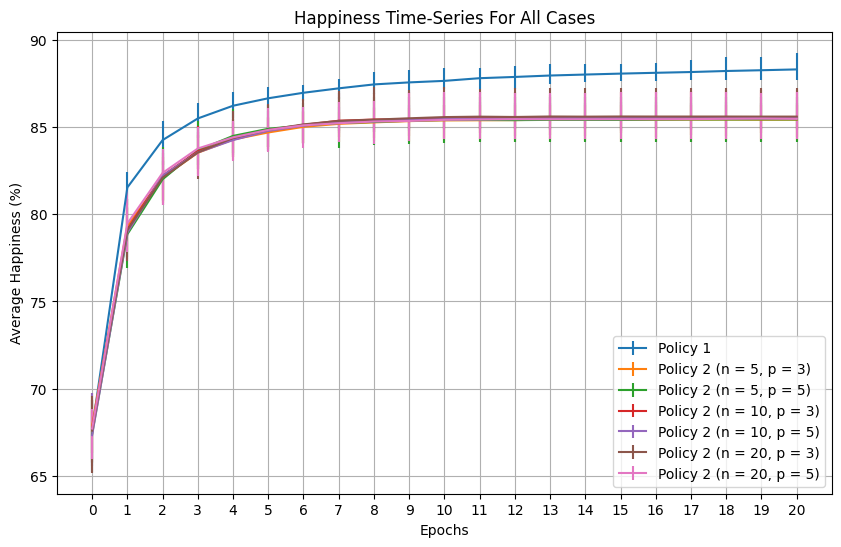

In [42]:
epochs = np.arange(21)

plt.figure(figsize=(10, 6))

plt.errorbar(epochs, policy1_happiness_avgs, yerr=policy1_happiness_err, label='Policy 1')
plt.errorbar(epochs, policy2_n5_p3_happiness_avgs, yerr=policy2_n5_p3_happiness_err, label='Policy 2 (n = 5, p = 3)')
plt.errorbar(epochs, policy2_n5_p5_happiness_avgs, yerr=policy2_n5_p5_happiness_err, label='Policy 2 (n = 5, p = 5)')
plt.errorbar(epochs, policy2_n10_p3_happiness_avgs, yerr=policy2_n10_p3_happiness_err, label='Policy 2 (n = 10, p = 3)')
plt.errorbar(epochs, policy2_n10_p5_happiness_avgs, yerr=policy2_n10_p5_happiness_err, label='Policy 2 (n = 10, p = 5)')
plt.errorbar(epochs, policy2_n20_p3_happiness_avgs, yerr=policy2_n20_p3_happiness_err, label='Policy 2 (n = 20, p = 3)')
plt.errorbar(epochs, policy2_n20_p5_happiness_avgs, yerr=policy2_n20_p5_happiness_err,label='Policy 2 (n = 20, p = 5)')

plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Average Happiness (%)')
plt.title('Happiness Time-Series For All Cases')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
policy2_n20_p5_happiness_avgs

array([67.678125, 80.73125 , 84.9625  , 87.371875, 88.834375, 90.021875,
       90.584375, 90.8375  , 90.990625, 91.065625, 91.09375 , 91.096875,
       91.121875, 91.13125 , 91.1375  , 91.140625, 91.140625, 91.140625,
       91.140625, 91.140625, 91.140625])